In [2]:
#ResNet 50 작성
#pakage

import torch
import torchvision
from torchvision import transforms
from torch import optim

import numpy as np

import pathlib

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(DEVICE))

import gc
gc.collect()
torch.cuda.empty_cache()

Using cuda device


In [3]:
#학습 이미지 다운로드 & 전처리
train_mean = [0.49139968,0.48215845,0.4465309]
train_std = [0.19525091,0.19247101,0.19419736]

test_mean = [0.4942143,0.48513138,0.45040908]
test_std = [0.19493015,0.19217026,0.19435139]

transform_train = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),transforms.Normalize(train_mean,train_std)])
transform_test = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),transforms.Normalize(test_mean,test_std)])



trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=1)

print(trainset)

print(trainset[0][0].shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215845, 0.4465309], std=[0.19525091, 0.19247101, 0.19419736])
           )
torch.Size([3, 224, 224])


In [ ]:
np.mean(trainset[0][0].numpy(),axis=(1,2))

In [ ]:
# 정규화를 위한 계산 함수
def getMeanStd(dataset):
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print(meanR, meanG, meanB)
    print(stdR, stdG, stdB)

In [5]:
#getMeanStd(trainset)

In [6]:
#getMeanStd(testset)

In [7]:
train_mean = [0.49139968,0.48215845,0.4465309]
train_std = [0.19525091,0.19247101,0.19419736]

test_mean = [0.4942143,0.48513138,0.45040908]
test_std = [0.19493015,0.19217026,0.19435139]

In [8]:
#정규화 적용하기
#trans_train = transforms.Compose([transforms.Normalize(train_mean,train_std)])
#trans_test = transforms.Compose([transforms.Normalize(test_mean,test_std)]) 

#trainset = torchvision.datasets.CIFAR10(root='./data', transform=trans_train)
#testset = torchvision.datasets.CIFAR10(root='./data', transform=trans_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


 출력 index :  [23087, 14538, 41648, 9975, 21015, 27758, 36880, 32848, 9830, 48659] / 총 10 개 이미지 



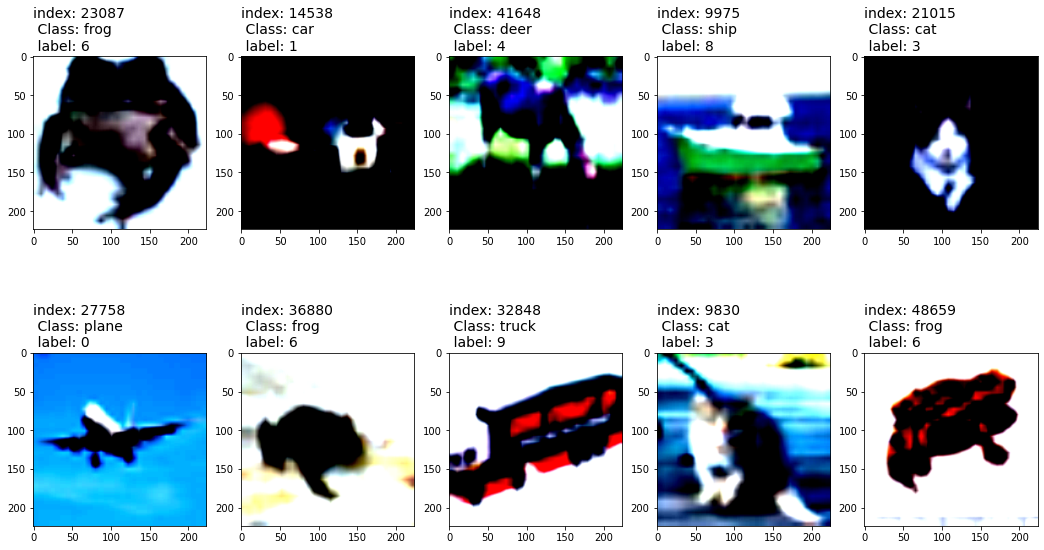

In [4]:
import random
import matplotlib.pyplot as plt
%matplotlib inline 

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#이미지 배열로 살펴보기

range_List = []

#리스트에 random index 저장
for i in range(10):
    ran = random.randint(0,49999)
    range_List.append(ran)



#figure size / 배열 설정
rows = 2
columns = 5
img_index = 0
plt.rcParams['figure.figsize'] = (18.0, 10.0)


title_font = {
    'fontsize': 14,
}

#figure안에 이미지 넣기
for i in range_List :
    img_index += 1
    img, label = trainset[i]
    header = 'index: {} \n Class: {} \n label: {}'.format(i,class_names[label],label)
    
    npimg = img.numpy()
    plt.subplot(rows, columns, img_index)
    plt.title(header,fontdict=title_font,loc='left')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
print('\n 출력 index : ',range_List,'/ 총',len(range_List),'개 이미지 \n')
plt.show()

In [5]:
#모델 아키텍처 구성
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

#레이어 구조
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [6]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [9]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(DEVICE) 

In [11]:
from torchsummary import summary as summary
summary(resnet50, input_size=(3, 224, 224), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 223, 223]           3,072
       BatchNorm2d-2         [-1, 64, 223, 223]             128
              ReLU-3         [-1, 64, 223, 223]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           2,048
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           9,216
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]           4,096
      BatchNorm2d-12        [-1, 128, 112, 112]             256
           Conv2d-13        [-1, 128, 112, 112]           8,192
      BatchNorm2d-14        [-1, 128, 1

In [12]:
from torchvision import models
import torch

resnet50_pretrained = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([64, 3, 4, 4])


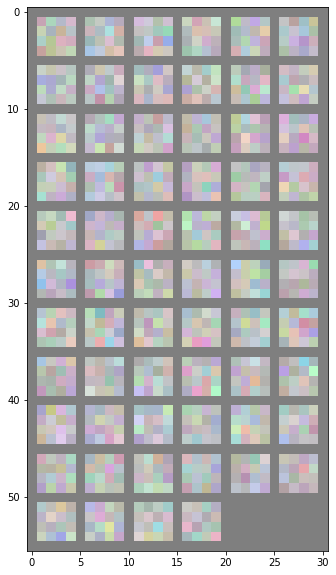

In [14]:
for w in resnet50.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# 가중치 renormalization
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=6, padding=1)

plt.figure(figsize=(10, 10))
imshow(x_grid)

In [15]:
# config 모델 파라미터 인자를 만들기위한 클래스
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [27]:
lr = 0.1
EPOCHS = 5
optimizer = torch.optim.Adam(model.parameters())

In [28]:
train_loader = trainloader
test_loader = testloader
model = resnet50
device = DEVICE
optimer = torch.optim.Adam(resnet50.parameters(), lr=lr)
device= nn.CrossEntropyLoss().to(device)
globaliter = 0

In [29]:
def train(model, device, train_loader, optimer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 300 == 0:
            print("epoch:{} [{}/{} ({:.0f}%)] \t Loss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [30]:
A_loss = []
V_Accuracy = []

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        
        loss = test_loss/10000
        loss = round(loss,4)
        A_loss.append(loss)
        
        acc = 100. * correct / len(test_loader.dataset)
        acc = round(acc)
        V_Accuracy.append(acc)
        
        test_loss /= len(test_loader.dataset)
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [31]:
EPOCH = []

for epoch in range(EPOCHS):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)
    EPOCH.append(1+epoch)

RuntimeError: ignored

In [20]:
# 2번째 학습 테스트 (위에 안되면 이거 이것도 안되면 답이없다..)

class train_test():
    def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
        
    def train(self, epochs, log_interval):
        self.model.train()
        for epoch in range(1, epochs + 1 ):  # epochs 루프
            running_loss = 0.0
            lr_sche.step()
            for i, data in enumerate(self.trainloader, 0): # batch 루프
                # get the inputs
                self.globaliter += 1
                inputs, labels = data # input data, label 분리
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                self.optimizer.zero_grad() 

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                # 30 iteration마다 acc & loss 출력
                if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                          epoch, i*len(inputs), len(self.trainloader.dataset),
                          100. * i*len(inputs) / len(self.trainloader.dataset), 
                          running_loss / log_interval,
                          loss.item()))
                    running_loss = 0.0

                    #with train_summary_writer.as_default():
                    #    summary.scalar('loss', loss.item() , step = self.globaliter)

            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0
                acc = []
                for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)

                print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                    ))
    print('Finished Training')

Finished Training


In [21]:
ready_to_train=train_test(config)

782


In [22]:
import gc
gc.collect()
torch.cuda.empty_cache()

lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=10000, gamma=0.5) # 20 step마다 lr조정
epochs = 10
log_interval = 172

ready_to_train.train(epochs, log_interval)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


RuntimeError: ignored